In [ ]:
conda install geopandas

In [ ]:
#!/usr/bin/env python
# coding: utf-8
#by Deependra Neupane

from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import shapely
from rasterio.warp import reproject, Resampling
import os
from rasterstats import zonal_stats
from shapely.ops import nearest_points
import matplotlib.pyplot as plt
import rasterio
from pyproj.crs import CRS
import numpy as np
from reproject import reproject_data
import subprocess
import gdal
import numpy as np

import matplotlib.pyplot as plt


In [3]:
#our projection System transverse mercator
projection_dict = {'proj': 'tmerc',
 'lat_0': 0,
 'lon_0': 84,
 'k': 0.9996,
 'x_0': 500000,
 'y_0': 0,
 'datum': 'WGS84',
 'units': 'm',
 'no_defs': None,
 'type': 'crs'}

base_dir= '/home/deep/Documents/PaperFiles/'
data_dir = base_dir + 'Data'
projected_dir = base_dir + 'Reproject_Data'
suitability_data = base_dir + 'poa'
# In[2] applying the exclusion on raster data sets
boundary = gpd.read_file(data_dir + '/Boudary Files/Provincial.shp')
poa = gpd.read_file(suitability_data + '/solar_final_poa.shp')
#poa = gpd.read_file('Final_maps/solar_poa.shp')
poa = poa.to_crs(CRS.from_dict(projection_dict))
poa_built = gpd.read_file(suitability_data + '/built_up.shp')
poa_built = poa_built.to_crs(CRS.from_dict(projection_dict))
#for calculaiton of distances
substation = gpd.read_file(data_dir + '/Substation/Substation_final_data.shp')
roads = gpd.read_file(data_dir + '/nepal_roads_gtsk_43/gstk_nepal_43_roads.shp')
protected = gpd.read_file(data_dir + '/Road and Protected/protected areas.shp')
protected = protected.to_crs(CRS.from_dict(projection_dict))
buffered_water_bodies = gpd.read_file(data_dir+ '/Water_Bodies/Buffered/water_100m.shp')
buffer_water = buffered_water_bodies.to_crs(CRS.from_dict(projection_dict))
##raster stats
ghi = data_dir + '/Solar_and_Temperature/DailySumGHI.tif'
w_density = data_dir + '/Wind Data/NPL_power-density_50m.tif' 
w_speed = data_dir + '/Wind Data/NPL_wind-speed_50m.tif' 
elevation = data_dir + '/DEM 90m Nepal/DEM Nepal/Digital_Elevation_Model_Nepal.tif'
aspect = data_dir +  '/DEM 90m Nepal/Aspect_data.tif'

feasible_land = data_dir + '/land_cover/grass_shrub_barren.tif'
slope = data_dir + '/DEM 90m Nepal/DEM Nepal/Nepal_Slope.tif'

template = data_dir + '/land_cover/Built_up_areas.tif'


In [15]:
re_ghi_data =reproject_data(ghi,projected_dir + "/ghi.tif", template)
re_feasible_data = reproject_data(feasible_land,projected_dir + "/feasible.tif", template)
re_slope_data =reproject_data(slope,projected_dir + "/slope.tif", template)
re_elevation_data =reproject_data(elevation,projected_dir + "/elevation.tif", template)
re_aspect_data = reproject_data(aspect,projected_dir + "/aspect.tif", template)

PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378

In [19]:
process = 'gdal_calc.py -A '+ re_ghi_data+' -B '+re_feasible_data+' -C '+re_slope_data+' -D '+re_elevation_data+' -E '+re_aspect_data+' --outfile=solar_poa.tif --calc="(A>=4.1)*B*(C<23)*(D<4000)*(112.5<E)*(E<247.5)"'

In [20]:
process

'gdal_calc.py -A /home/deep/Documents/PaperFiles/Reproject_Data/ghi.tif -B /home/deep/Documents/PaperFiles/Reproject_Data/feasible.tif -C /home/deep/Documents/PaperFiles/Reproject_Data/slope.tif -D /home/deep/Documents/PaperFiles/Reproject_Data/elevation.tif -E /home/deep/Documents/PaperFiles/Reproject_Data/aspect.tif --outfile=solar_poa.tif --calc="(A>=4.1)*B*(C<23)*(D<4000)*(112.5<E)*(E<247.5)"'

In [21]:
subprocess.call(process, shell=True)

0

In [32]:
process2 = 'gdal_calc.py -A solar_poa.tif --outfile=final_solar.tif --calc="(A>=1)" --NoDataValue=0'
process2

'gdal_calc.py -A solar_poa.tif --outfile=final_solar.tif --calc="(A>=1)" --NoDataValue<=0'

In [33]:
subprocess.call(process2, shell=True)

2

In [9]:
import rasterio
import numpy as np

with rasterio.open('solar_poa.tif') as src:    
    # Read as numpy array
    array = src.read()
    profile = src.profile

    # Reclassify
    array[np.where(array == 0)] = np.nan 
    array[np.where(array == 1)] = 1
    # and so on ...  

with rasterio.open('output_raster.tif', 'w', **profile) as dst:
    # Write to disk
    dst.write(array)

In [9]:
process1 = 'gdal_polygonize.py output_raster.tif -f "ESRI Shapefile" data/mylayer.shp'

In [12]:
subprocess.call(process1, shell=True)

KeyboardInterrupt: 

In [3]:
#water bodies exlcusion
poa = gpd.overlay(poa, buffer_water, how='difference', make_valid=True, keep_geom_type=True)
poa['Area'] = poa.area
poa = poa.query('Area>=900')

In [13]:
def dict_arr(stat):
    arr =[]
    for i in range(len(stat)):
        value = stat[i]['mean']
        arr.append(value)
    return arr

In [9]:
def min_distance(poa,place):
    pbar = tqdm(total=len(poa))
    print("forming Unary_union")
    place= place.to_crs(poa.crs).unary_union
    print("Unary Formation complete")
    distance =[]
    for p in poa.geometry:
        nearest_geoms = nearest_points(p, place)
        min_dist = nearest_geoms[0].distance(nearest_geoms[1])
        distance.append(min_dist)
        pbar.update(1)
    pbar.close()
    return distance 

In [10]:
#Finding nearst Distance
poa['d_sub'] = min_distance(poa,substation)
poa['d_roads'] = min_distance(poa,roads)

  0%|          | 367/98781 [00:00<01:30, 1084.23it/s]

forming Unary_union
Unary Formation complete


  0%|          | 0/98781 [00:00<?, ?it/s]

forming Unary_union


  0%|          | 6/98781 [00:01<25:58:23,  1.06it/s]

Unary Formation complete


100%|██████████| 98781/98781 [23:37<00:00, 69.69it/s]  


In [11]:
#finding zonal Stats
poa['avg_ghi'] = dict_arr(zonal_stats(poa.geometry,reproject_data(ghi,projected_dir + "/ghi.tif", template),stats="mean",all_touched = True))
poa['elevation'] = dict_arr(zonal_stats(poa.geometry,reproject_data(elevation,projected_dir + "/elevation.tif", template),stats="mean",all_touched = True))

PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378

In [72]:
poa['Area'] = poa.area/1000000

In [73]:
l_e = 30
d_f = 1
#from solar model
poa['cf'] =poa['avg_ghi']*0.0449187 +(-0.0745561)
poa['incap'] = poa.Area*l_e*d_f #mw


KeyError: 'avg_ghi'

In [74]:
#calculation of LCOE
hours = 8760
tdm =1.3
i=0.1
n=25
I_c =1210000 #per mw
O_gc = 10000#per mw
T_c = 450#mw/km
d_s = poa["d_sub"] * tdm/1000
S_c = 70000#/mw
R_c = 60000#/km
d_r =poa['d_roads']/1000
cf = poa['cf']
i_d = (i*(1+i)**n)/(((1+i)**n)-1)

KeyError: 'd_sub'

In [16]:
def calc_cost():
    lt_gen = []
    lt_tra = []
    for i in range(len(poa)):
        gen_cost = (I_c*i_d + O_gc )/(cf.values[i]*hours)
        lt_gen.append(gen_cost)

    for i in range(len(poa)):
        l_road = ((R_c*d_r.values[i])*i_d)/(cf.values[i]*70*hours)
        l_sub = ((T_c*d_s.values[i] + S_c)*i_d)/(cf.values[i]*hours)
        lt = l_road+l_sub
        lt_tra.append(lt)
    return [lt_gen,lt_tra]
a = calc_cost()

In [17]:
poa['lt_gen'] = a[0]
poa['lt_tra'] = a[1]
poa['lt_tot'] = poa['lt_gen']+poa['lt_tra']

In [18]:
egen = []
for i in range(len(poa)):
    a = 30*poa.Area.values[i]*cf.values[i]*8760
    egen.append(a)
poa['egen'] = egen

In [31]:
data = poa.query('Area>=0.0009')
data.to_file(suitability_data +'/solar_poa_water_excluded.shp')

In [4]:
data = gpd.read_file(suitability_data +'/solar_poa_water_excluded.shp')

<h2>Finding Provincial Capacity</h2>

In [14]:
#provincial potential estimation
def find_capacity(poa, boundary):
    install_potential = []
    generation = []
    prov_name = []
    area = []
    data = pd.DataFrame()
    boundary = boundary.to_crs(poa.crs)
    for name in boundary.Name:
        print('Calculation of' + name + 'is Complete')
        Province =  boundary[boundary["Name"] == name].geometry
        poly_gdf = gpd.GeoDataFrame(geometry=Province, crs=boundary.crs)
        proclip = gpd.overlay(poa, poly_gdf, how='intersection', make_valid=True, keep_geom_type=True)
        install_potential.append(proclip.incap.sum())
        area.append(proclip.area.sum())
        generation.append(proclip.egen.sum())
        prov_name.append(name)
        
    data['Name'] = prov_name
    data['Area'] = area
    data['Capacity'] = install_potential
    data['Generation'] = generation
    return data

In [ ]:
prov_data = find_capacity(data,boundary)
prov_data.to_csv('solar_potential.csv')

In [11]:
import matplotlib
plt.rcParams.update({'font.size': 15})

In [12]:
#%%finding moving average
def calc_mov_avg(numbers,size):
    
    window_size = size

    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    return moving_averages

In [13]:
sd_sort = data.sort_values('lt_tot')
egen = pd.DataFrame(sd_sort, columns = ['egen'])
sd_sort['cum_egen_TWh'] = egen.cumsum()/1000000

<h2>Distance Analysis</h2>

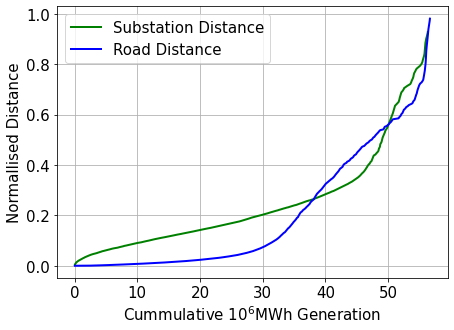

In [14]:
#Distance Analysis
#%% Distance Analysis
d_sort = data.sort_values('d_sub')
egen = pd.DataFrame(d_sort, columns = ['egen'])
d_sort['cum_egen_sub'] = egen.cumsum()/1000000
s_power_sub = pd.DataFrame(d_sort, columns =['cum_egen_sub']).round(decimals=2).to_numpy()
d_sub = pd.DataFrame(d_sort, columns = ['d_sub']).to_numpy()
d_sort= data.sort_values('d_roads')
egen = pd.DataFrame(d_sort, columns = ['egen'])
d_sort['cum_egen_road'] = egen.cumsum()/1000000
s_power_road = pd.DataFrame(d_sort, columns =['cum_egen_road']).round(decimals=2).to_numpy()
d_road = pd.DataFrame(d_sort, columns = ['d_roads']).to_numpy()

fig,ax= plt.subplots(1,1 ,figsize=(7,5))
plt.plot(calc_mov_avg(s_power_sub,100),calc_mov_avg(d_sub/max(d_sub),100), 'g',lw=2)
plt.plot(calc_mov_avg(s_power_road,100),calc_mov_avg(d_road/max(d_road),100), 'b', lw=2)
plt.legend(['Substation Distance','Road Distance'])
plt.grid()
#plt.ylim((50, 210)) 
plt.xlabel('Cummulative $10^6$MWh Generation')
plt.ylabel('Normallised Distance')
plt.savefig('Images/solar_distance.png')
plt.show()

<h2>Project Attribute Analysis</h2>

In [15]:
sd  = data
df = sd.query("cf >0.15")

sd_sort = df.sort_values('lt_tot')
egen = pd.DataFrame(sd_sort, columns = ['egen'])
sd_sort['cum_egen_TWh'] = egen.cumsum()/1000000

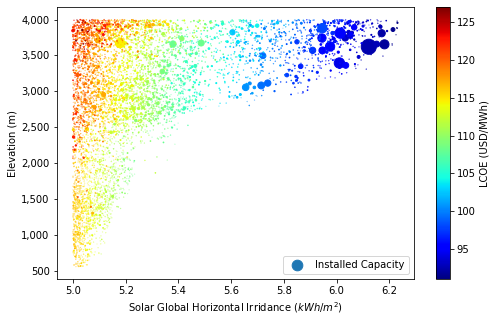

In [58]:
fig,ax = plt.subplots(1,1 ,figsize=(8,5))
CS = plt.scatter( x = sd_sort['avg_ghi'], y = sd_sort['elevation'], s = sd_sort['incap']/2,label = 'Installed Capacity', 
            c = sd_sort['lt_tot'], cmap = plt.get_cmap('jet'))

plt.xlabel('Solar Global Horizontal Irridance ($kWh/m^2$)')
ax.legend()
plt.ylabel('Elevation (m)')
fig.colorbar(CS, label="LCOE (USD/MWh)")
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('Images/final_solar_analysis.png')
plt.show()

<h2>Potential in Built up Areas</h2>

In [15]:
poa_built['avg_ghi'] = dict_arr(zonal_stats(poa_built.geometry,reproject_data(ghi,projected_dir + "/ghi.tif", template),stats="mean",all_touched = True))
poa_built['cf'] = poa_built['avg_ghi']*0.0449187 +(-0.0745561)
poa_built = poa_built.query('avg_ghi>=4.1')

PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",84],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [16]:
poa_built['Ava_A'] = (poa_built.area )* 0.5*0.5*0.4
poa_built['incap'] =  (poa_built.Ava_A * 150)/1000000
poa_built['egen'] = poa_built.incap*8760*poa_built.cf

In [17]:
prov_built_data = find_capacity(poa_built,boundary)

Calculation ofProvince 1is Complete
Calculation ofProvince 2is Complete
Calculation ofBagmati Provinceis Complete
Calculation ofGandaki Provinceis Complete
Calculation ofProvince 5is Complete
Calculation ofKarnali Provinceis Complete
Calculation ofSudurpashim Provinceis Complete


In [18]:
poa_built.egen.sum()/1000

9527.508066679911

In [19]:
import matplotlib
labels = ['Province 1','Province 2','Bagmati', 'Gandaki', 'Province 5', 'Karnali','Sudurpashim']
generation = prov_built_data.Generation/1000000
province_area = [102,103,211,58,30,13,26]
built_up =pd.DataFrame()
built_up['generation'] = generation*1000
built_up['name'] = labels
built_up['area'] = province_area
built_up = built_up.set_index('name')

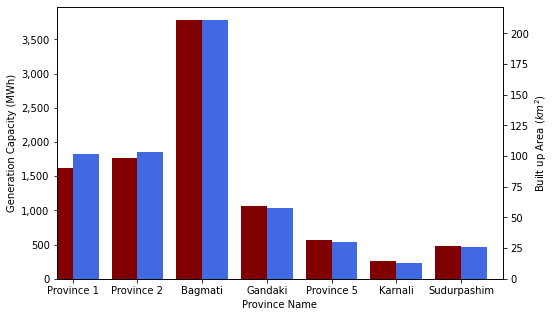

In [20]:

fig,ax= plt.subplots(1,1 ,figsize=(8,5)) # Create matplotlib figure

 # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

built_up.generation.plot(kind='bar', color='maroon', ax=ax, width=width, position=1,rot = 0)
built_up.area.plot(kind='bar', color='royalblue', ax=ax2, width=width, position=0)

ax.set_ylabel('Generation Capacity (MWh)')
ax2.set_ylabel('Built up Area ($km^2$)')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('Province Name')
plt.savefig('Images/solar_builtup')
plt.show()

In [21]:
prov_built_data

,Name,Area,Capacity,Generation
0,Province 1,9.964376e+07,1495.0170,1.617632e+06
1,Province 2,1.026144e+08,1539.3510,1.768495e+06
2,Bagmati Province,2.110167e+08,3165.2505,3.783447e+06
3,Gandaki Province,5.799870e+07,869.9805,1.060267e+06
4,Province 5,3.034530e+07,455.1795,5.610448e+05
5,Karnali Province,1.328400e+07,199.2600,2.533624e+05
6,Sudurpashim Province,2.645190e+07,396.7785,4.832461e+05


In [22]:
#calculation of LCOE
hours = 8760
i=0.1
n=25
I_c =1210000 #per mw
O_gc = 10000#per mw
i_d = (i*(1+i)**n)/(((1+i)**n)-1)
cf = poa_built.cf
def calc_cost():
    lt_gen = []
    for i in range(len(poa_built)):
        gen_cost = (I_c*i_d + O_gc )/(cf.values[i]*hours)
        lt_gen.append(gen_cost)
    return lt_gen
poa_built['lt_gen'] = calc_cost()

<h2>Geospatial Supply Curve</h2>

In [23]:
sd_sort_feasible = data.sort_values('lt_tot')
egen_feasible = sd_sort_feasible.egen
sd_sort_feasible['cum_egen_TWh'] = egen_feasible.cumsum()/1000000
s_cost_sub = sd_sort_feasible.lt_tot.values
s_power = sd_sort_feasible.cum_egen_TWh.values
s_cost_gen = sd_sort_feasible.lt_gen.values

In [24]:
sd_sort_built = poa_built.sort_values('lt_gen')
egen_built = pd.DataFrame(sd_sort_built, columns = ['egen'])
sd_sort_built['cum_egen_TWh'] = egen_built.cumsum()/1000000

In [25]:
built_lt_gen = calc_mov_avg(sd_sort_built.lt_gen,50)
built_egen = calc_mov_avg(sd_sort_built.cum_egen_TWh, 50)
feasible_lt_tot = calc_mov_avg(s_cost_sub,50)
feasible_egen = calc_mov_avg(s_power, 50)
feasible_lt_gen = calc_mov_avg(s_cost_gen,50)

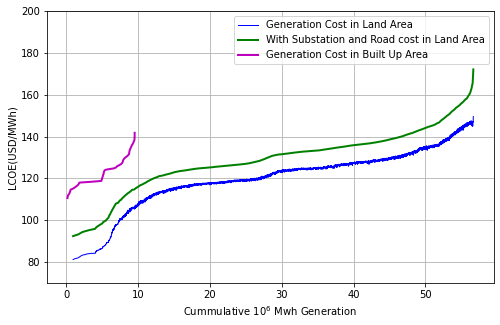

In [27]:
fig,ax= plt.subplots(1,1 ,figsize=(8,5))
plt.plot(feasible_egen,feasible_lt_gen, 'b', lw = 1)
plt.plot(feasible_egen,feasible_lt_tot, 'g', lw = 2)
plt.plot(built_egen,built_lt_gen, 'm', lw = 2)
plt.legend(['Generation Cost in Land Area', 'With Substation and Road cost in Land Area', 'Generation Cost in Built Up Area'])
plt.grid()
plt.ylim((70, 200)) 
plt.xlabel('Cummulative $10^6$ Mwh Generation')
plt.ylabel('LCOE(USD/MWh)')
plt.savefig('Images/solar_GSC.png')
plt.show()

<h2>Potential in Protected Areas</h2>

In [40]:
#in protected region
poa_protected = gpd.overlay(poa, protected, how='intersection', make_valid=True, keep_geom_type=True)
in_protected_data = find_capacity(poa_protected,boundary)
in_protected_data.to_csv('solar_protected.csv')

Province 1
Province 2
Bagmati Province
Gandaki Province
Province 5
Karnali Province
Sudurpashim Province


<h2>Land Distribution</h2>

In [ ]:
#Land distribution
land_distri = pd.DataFrame()
Prov_name = ['Province 1', 'Province 2', 'Bagmati Province', 'Gandaki Province',
       'Province 5', 'Karnali Province', 'Sudurpashim Province']
grassland = [2191,144,1632,3217,705,5371,2093]
barren=[1027,509,713,2945,638,5827,984]
shrub=[677,75,238,696,251,963,527]
area = [25905,9661,20300,21504,22288,27984,19539]
land_distri['Prov_name'] = Prov_name
land_distri['Grassland'] = grassland
land_distri['Shrubland'] = shrub
land_distri['Barrenland'] = barren
land_distri['Area'] = area

In [ ]:
land_distri['totalfeasible'] = land_distri.Grassland + land_distri.Shrubland + land_distri.Barrenland
land_distri['percentfeasible']= land_distri.totalfeasible/land_distri.Area

<h2>Testing the data</h2>

In [18]:
deep_data = data.query('d_sub<=20000')
len(deep_data)/len(data)

0.7060973264089248

In [12]:
max(data.Area)

15.134936850822369

In [20]:
data.egen.sum()

56692300.24382295

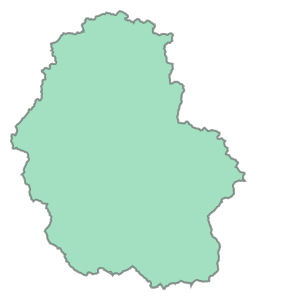

In [32]:
protected.loc[15].geometry

In [30]:
annapurna_gnom = protected.loc[15].geometry

In [35]:
poa_annapurna = gpd.clip(data, annapurna_gnom, keep_geom_type=True)

In [37]:
poa_annapurna.incap.sum()

5431.797613696052